In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
# Load the data
file_path = r"C:\Users\daves\OneDrive\Pessoal\Acadêmico\Mestrado\Dissertação - Execução\Análises\Dados do Censo - não usar na regressão\PIA individuais.xlsx"
df = pd.read_excel(file_path, sheet_name="Cuiabá")

# Filter out zeros or negative values before log transformation
df = df[df['Totalammount'] > 0].copy()
df['log_Totalammount'] = np.log(df['Totalammount'])

# List of municipalities
municipalities = [
    "Acorizal", "Barão de Melgaço", "Campo Verde", "Chapada dos Guimarães",
    "Cuiabá", "Jangada", "Nobres", "Nossa Senhora do Livramento",
    "Nova Brasilândia", "Planalto da Serra", "Poconé", "Rosário Oeste",
    "Santo Antônio do Leverger", "Várzea Grande"
]

# Colors and line styles
colors = [
    'green', 'green', 'blue', 'blue',
    'red', 'black', 'black', 'yellow',
    'yellow', 'orange', 'purple', 'gray',
    'gray', 'brown'
]

line_styles = [
    '--', '-', '--', '-',
    '--', '-', '--', '-',
    '--', '-', '--', '-',
    '--', '-'
]

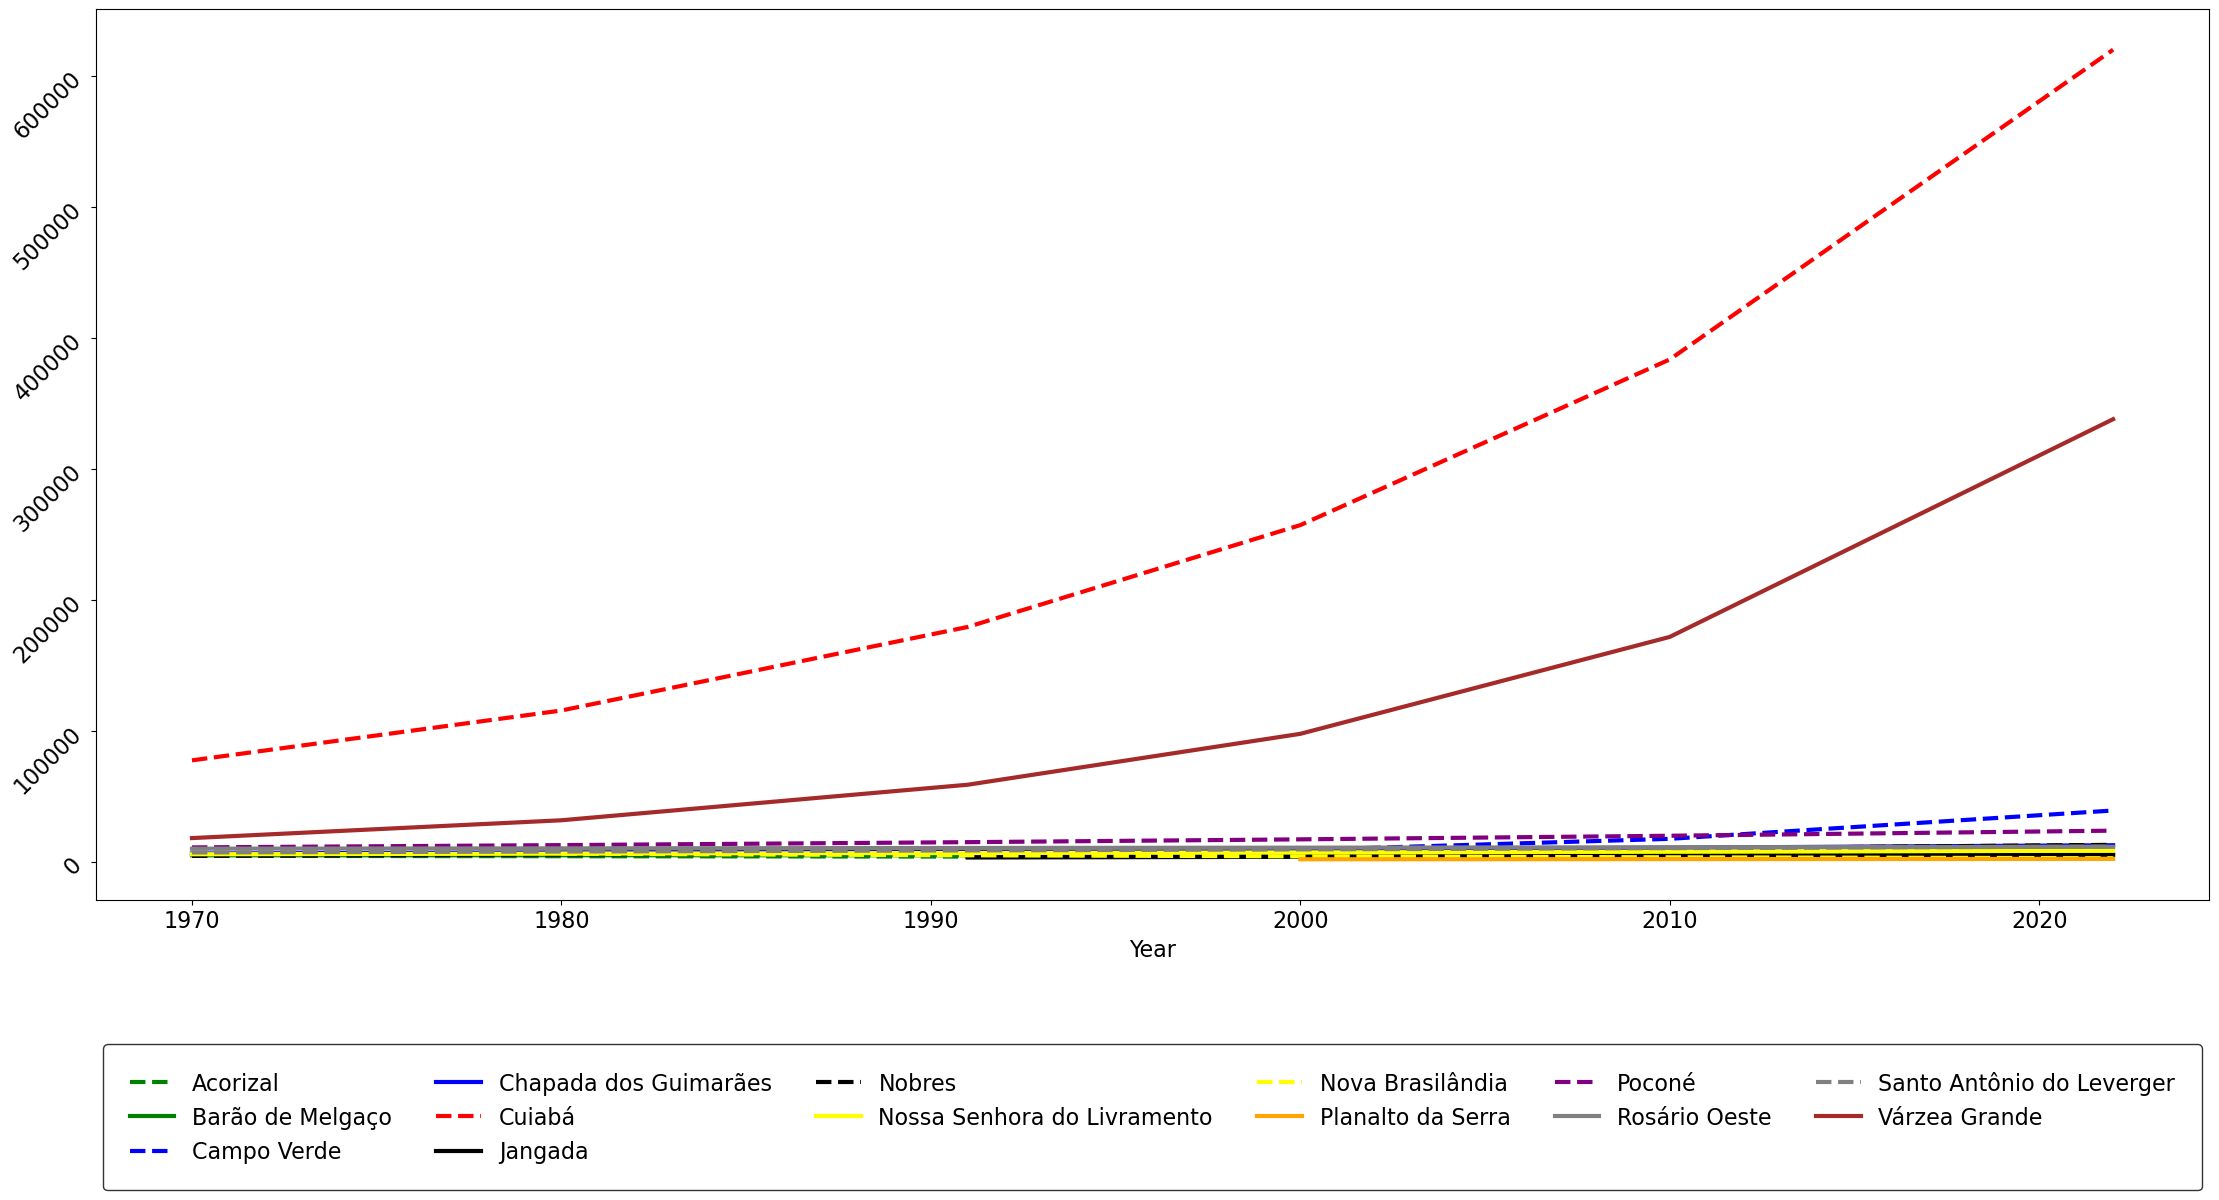

In [8]:
# Create figure with larger size to accommodate bigger fonts
plt.figure(figsize=(24, 16))

# Set global font size to 16
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

# For each municipality, perform exponential fit and plot
for i, mun in enumerate(municipalities):
    mun_df = df[df['Municipios'] == mun]
    if len(mun_df) >= 2:  # Need at least 2 points for a fit
        try:
            # Fit log-linear model (equivalent to exponential)
            X = sm.add_constant(mun_df['Year'])
            y = mun_df['log_Totalammount']
            model = sm.OLS(y, X).fit()
            
            # Generate predictions
            years = np.array(sorted(mun_df['Year'].unique()))
            X_pred = sm.add_constant(years)
            log_pred = model.predict(X_pred)
            pred = np.exp(log_pred)
            
            # Plot the fitted line with thicker lines
            plt.plot(years, pred, 
                     color=colors[i], 
                     linestyle=line_styles[i], 
                     linewidth=3.0,
                     label=mun)
        except:
            print(f"Could not fit exponential curve for {mun} - possibly insufficient data")
            continue

# Customize the plot - REMOVED Y-AXIS LABEL
plt.xlabel('Year', fontsize=16)
plt.ylabel('')  # Empty string removes y-axis label
plt.yticks(rotation=45)
plt.grid(False)

# Legend settings with larger font
legend = plt.legend(
    fontsize=16,
    ncol=6,
    bbox_to_anchor=(0.5, -0.15),
    loc='upper center',
    frameon=True,
    framealpha=0.8,
    edgecolor='black',
    borderpad=1.2
)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0.15, 1, 0.95])

# Save the plot with 1200 DPI
output_path = r"C:/Users/daves/OneDrive/Pessoal/Acadêmico/Mestrado/Dissertação - Execução/Dissertação/Quadros e gráficos/Graph8.jpg"
plt.savefig(output_path, dpi=1200, bbox_inches='tight', facecolor='white')

plt.show()